# Education Data Workbook Assignment
## By Abu Nayeem 07/30/24 (Revised 08/01/24)

## Table of contents <a name="content"></a>
* [Assignment](#a)
* [Load Data](#0)
* [Data Cleaning & Validation](#1.0)
    * [Clean Score Data](#1.1)
    * [Clean Site List Data](#1.2)
    * [Clean Student Data](#1.3)
* [Prepare Student Data](#2.0)
* [Data Merge & Export](#3.0)
* [Data Visualization](#4.0)
    * [Student Ethnicity](#4.1)
    * [Housing Status](#4.2)
    * [Poverty Status](#4.3)
* [Programmer Note](#program)

## Assignment <a name="a"></a>

### Data Sets Provided:
* Site List: Details each site, including Source Site ID, Program Name, Users, and more.
* Students: Information on students, including Assigned Site ID, Birth Date, Ethnicity, Meal Code, Housing Status, and Source Class ID.
* Implementation Score: Includes Source Site ID, Age Group (3K or PK), and Score.
* Code Descriptions: Provides descriptions for Ethnicity, Meal Code, and Housing Status codes

### Cleaning Requirements:
* Ensure all fields are filled and formatted correctly (e.g. Dates, Codes, etc). Removeinvalid data if any.
* Verify student ages, Ethnicity, Meal Code, and Housing Status against provided descriptions.
* Validate scores and calculate averages for each site by Age Group.
* Also, for Source Site IDs, the third character in six character ID corresponds to Borough, and first character in 4 character corresponds to the Borough. K=Brooklyn, X=Bronx, M=Manhattan, X=Queens, R=Staten Island


### Data Integration and Flat File Creation:
#### Create a flat file with Source Site ID as the key observation, including:
* No Site/Program added prior to August 2024 should be identified as possibly invalid.
* Total Users per site.
* Total students aged 5 and younger per site.
* Total valid classes per site (exclude "demo" classes).
* Average implementation score for each Age Group per site.
* You may add other columns tot he flat file if you feel it is important. 

### Visual Reports:
* Student demographics by Ethnicity.
* Breakdown by Housing Status.
* Percentage of students receiving free or reduced lunch (economically disadvantaged).

## 0. Load Data <a name="0"></a>

In [397]:
#Step 1 Load programs and extract data from Excel file 

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Note column names changed for standard naming procedure
SiteList = pd.read_excel(r"Edu_DataWorkbook.xlsx", sheet_name="Site List")
SiteList.columns= ['SourceSiteID','ProgramName','SiteID','Users','ProgramID','ProgramAddDate']
Students = pd.read_excel(r"Edu_DataWorkbook.xlsx", sheet_name="Students")
Students.columns= ['StudentID','AssignedSiteID','BirthDate','Ethnicity', 'Meal_Code','Housing_Status','IEP','SourceClassID']
Score = pd.read_excel(r"Edu_DataWorkbook.xlsx", sheet_name="Implementation Score")
Score.columns= ['SourceSiteID','AgeGroup','Score']

# Renamed Columns is not needed; NOTE: these tables serve as dictionary and not used for merging
EthnicCode = pd.read_excel(r"Edu_DataWorkbook.xlsx", sheet_name="Ethnic Code")
MealCode = pd.read_excel(r"Edu_DataWorkbook.xlsx", sheet_name="Meal Code")
HousingCode = pd.read_excel(r"Edu_DataWorkbook.xlsx", sheet_name="Housing Status")


# 1. Data Cleaning & Validation <a name="1.0"></a>

## Overall Strategy

Based on the file task there will be some merging with all the datasets. Few things to consider:
* Tidy up dataset
* Uniqueness of key parameters merging (i.e. SourceSiteID and SiteID) 
* Merge the Datasets

## 1.1 Clean up Score Data <a name="1.1"></a>

This should be the easiest (does not involve dates!). Our primary goal is to **flatten** the dataset on SourceSiteID where SourceSiteID is the unique identifier and for each row there is a corresponding 3K Score and PK Score

### Strategy
* I'll be splitting the Score table into two based on AgeGroup: 3KScore and PKScore
* Using the 3KScore as the base, I'll **merge** with PKScore to get a single clean table

### General Notes
* Some exclusion choices have been updated after viewing other tables
* I'm fine with 'missing' data for PK or 3K scores. I dont think its grounds for exclusion.

In [391]:
#Starting Point
print(Score.dtypes) #display datatypes
print(Score.shape) #display dimensionality 
Score.head(5)

SourceSiteID     object
AgeGroup         object
Score           float64
dtype: object
(1000, 3)


,SourceSiteID,AgeGroup,Score
0,92MO2V,3K,37.3
1,92MO2V,PK,87.4
2,MB40,3K,86.9
3,MB40,PK,82.5
4,95MIPS,3K,52.4


In [398]:
#Data Cleaning and validation

#Test if each SourceSiteID only has two entries: Strategy create an index column of (1) and then group by SourceSiteID
test_Score= Score.assign(Index=1) #creates new column Index 
p=['SourceSiteID', 'Index']
c= test_Score[p].groupby(['SourceSiteID',]).sum()
#c.rename(columns={'Index':'Count'}, inplace=True)
print(c.sort_values(by=['Index'])) # QIOS appears four times

print(test_Score.query("SourceSiteID=='QIOS'"))

#NOTE in retrospect I have removed QIOS because an issue appeared on Site List table
Score= Score[Score.SourceSiteID!='QIOS']

#INTIAL DECISION
# I'll be removing index 598 and 599
#Score= Score.drop(index=[598,599])
#The data is now validated 



              Index
SourceSiteID       
42K2GI            2
Q3ZP              2
Q3ZN              2
Q2QO              2
Q280              2
...             ...
72KDB5            2
72K89G            2
72XUB7            2
XZIT              2
QIOS              4

[499 rows x 1 columns]
    SourceSiteID AgeGroup  Score  Index
598         QIOS       3K   78.9      1
599         QIOS       PK    NaN      1
726         QIOS       3K   78.9      1
727         QIOS       PK   71.8      1


In [399]:
# Flattening the Data

_3KScore= Score.query("AgeGroup=='3K'")
_3KScore= _3KScore.drop('AgeGroup', axis=1) #remove AgeGroup column
_3KScore.rename(columns={'Score':'_3KScore'},inplace= True) #rename Score

PKScore= Score.query("AgeGroup=='PK'")
PKScore= PKScore.drop('AgeGroup', axis=1)
PKScore.rename(columns={'Score':'PKScore'},inplace= True)

#merge 
Score_Flat= pd.merge(_3KScore, PKScore, on='SourceSiteID', how='right') 


Score_Flat.head(5)

,SourceSiteID,_3KScore,PKScore
0,92MO2V,37.3,87.4
1,MB40,86.9,82.5
2,95MIPS,52.4,NaN
3,XWWY,76.3,52.0
4,QDAK,58.3,NaN


In [400]:
#The Next step is retrieving borough information from SourceSiteD

Score_Flat['Char_Num']= Score_Flat['SourceSiteID'].str.len()
# check if character numbers deviate from 4 or 6
print(Score_Flat[(Score_Flat.Char_Num!=4) & (Score_Flat.Char_Num!=6)])
#Looks Good

# K=Brooklyn, X=Bronx, M=Manhattan, X=Queens, R=Staten Island
    
    
# Split the data into two datatable with character 4 and 6

Score_Flat4= Score_Flat[(Score_Flat.Char_Num==4)]
Score_Flat6= Score_Flat[(Score_Flat.Char_Num==6)]

#Create new columns
Score_Flat4['Borough']= Score_Flat4.SourceSiteID.astype(str).str[0] #convert to string and slice
Score_Flat6['Borough']= Score_Flat6.SourceSiteID.astype(str).str[2]
Score_Flat_A = pd.concat([Score_Flat4,Score_Flat6], ignore_index=True)

Score_Flat_A.head(5)
# CHeck if there is any non-sensical code
print(Score_Flat_A['Borough'].value_counts())

#Create Function renaming Borough
def borough(x): 
    if x =='K':
        return 'Brooklyn'
    elif x =='X':
        return 'Bronx'
    elif x=='Q':
        return 'Queens'
    elif x =='M':
        return 'Manhattan'
    elif x =='R':
        return 'Staten_Island'
    else: 
        return 'Unknown'

Score_Flat_A['Borough']= Score_Flat_A['Borough'].apply(borough)
Score_Clean=Score_Flat_A.drop('Char_Num', axis=1)
Score_Clean.head(5)
    

Empty DataFrame
Columns: [SourceSiteID, _3KScore, PKScore, Char_Num]
Index: []
Q    110
R    104
M     96
X     94
K     94
Name: Borough, dtype: int64


,SourceSiteID,_3KScore,PKScore,Borough
0,MB40,86.9,82.5,Manhattan
1,XWWY,76.3,52.0,Bronx
2,QDAK,58.3,NaN,Queens
3,XL5F,24.5,93.7,Bronx
4,KJLD,65.8,33.3,Brooklyn


In [244]:
# Sandbox

#Score_Flat4.SourceSiteID.astype(str).str[0]

1      M
3      X
4      Q
5      X
7      K
      ..
491    Q
492    Q
493    K
494    X
497    X
Name: SourceSiteID, Length: 259, dtype: object

## 1.2 Clean up Site List Data <a name="1.2"></a>

### Strategy
* Standard Cleaning

### General Notes
* column ProgramID was dropped because lack of correlation with ProgramName and there is little variation in 
* I assume that the Program Name is correct (no way to validate claim)

In [401]:
#Starting Point
print(SiteList.dtypes)
print(SiteList.shape)
SiteList.head(5)

SourceSiteID      object
ProgramName       object
SiteID             int64
Users              int64
ProgramID          int64
ProgramAddDate    object
dtype: object
(500, 6)


,SourceSiteID,ProgramName,SiteID,Users,ProgramID,ProgramAddDate
0,92MO2V,CBO,948726,7,36460,"Dec 23, 2024"
1,MB40,CBO,928529,10,36460,"Dec 14, 2024"
2,95MIPS,CBO,977582,15,36460,26 Oct 2024
3,XWWY,CBO,900767,11,36460,"Oct 15, 2024"
4,QDAK,CBO,937750,10,36460,"Dec 24, 2024"


In [402]:
#Test for uniqueness of Site ID
SiteList.SiteID.is_unique # it says false!
SiteList.SiteID.value_counts() #indicates SiteID '966454' has issue
#print(SiteList[SiteList.SiteID=='966454'])
SiteList= SiteList.query('SiteID!=966454')

#check Again
print(SiteList.SiteID.is_unique) #Check again

#Test for uniqueness for Source Site ID
SiteList.SourceSiteID.is_unique #Check again

SiteList.SourceSiteID.value_counts()
print(SiteList.query("SourceSiteID=='QIOS'")) # the second time QIOS popped up
SiteList=SiteList.query("SourceSiteID!='QIOS'")

print(SiteList.SourceSiteID.is_unique) #Check again and its cleared


# CHeck if there is any non-sensical code
SiteList['ProgramID'].value_counts() #the vast majority of data is programID 36460, thus this column is not important
SiteList['ProgramName'].value_counts() # this has valuable information


True
    SourceSiteID      ProgramName  SiteID  Users  ProgramID ProgramAddDate
299         QIOS              CBO  954889     10      36460     08-10-2024
363         QIOS  District School  956160      7      36460     10/25/2024
True


CBO                298
District School    174
PreK                24
Name: ProgramName, dtype: int64

In [403]:
# Converting Dates

#Convert Date to Datetime!
from datetime import datetime

SiteList['ProgAddDateTime']= pd.to_datetime(SiteList['ProgramAddDate'])

#print(SiteList.head(50)) # looking at output; the conversion seems correct

SiteList['ProgAddYear']= SiteList['ProgAddDateTime'].dt.year 
print(SiteList['ProgAddYear'].value_counts())
#SiteList['ProgAddMonth']= SiteList['ProgAddDateTime'].dt.month
#SiteList['ProgAddDay']= SiteList['ProgAddDateTime'].dt.dayofyear


def progValid(x):
    if x < pd.to_datetime('2024-08-01'):
        return 'Yes'
    else:
        return 'Maybe'
    
SiteList['ProgValidity']= SiteList['ProgAddDateTime'].apply(progValid) #apply function


p=['SourceSiteID','SiteID', 'ProgramName','ProgAddDateTime','ProgValidity','Users']
SiteList_Clean= SiteList[p]

SiteList_Clean.head(5)
#SiteList.head(50)

2024    257
2025    239
Name: ProgAddYear, dtype: int64


,SourceSiteID,SiteID,ProgramName,ProgAddDateTime,ProgValidity,Users
0,92MO2V,948726,CBO,2024-12-23,Maybe,7
1,MB40,928529,CBO,2024-12-14,Maybe,10
2,95MIPS,977582,CBO,2024-10-26,Maybe,15
3,XWWY,900767,CBO,2024-10-15,Maybe,11
4,QDAK,937750,CBO,2024-12-24,Maybe,10


## 1.3 Clean up Student Data <a name="1.3"></a>

### Strategy
* Standard Cleaning

### General Notes
* The Student ID is not unique with 1/5 entries are duplicates. Excluding that much data is too much. I've dropped the StudentID column
* I created a dummy variable for Free and Reduced Lunch to perform aggregaation
*  I created a dummy variable for Housing Insecurity to perform aggregation and provide concise value of needs
* The task requires children being five or younger; so I was wary not use rounded function to find students age
* I did not exclude students for being too old
* IEP was excluded for insufficient entries

In [404]:
#Starting Point
print(Students.dtypes)
print(Students.shape)
Students.head(5)

StudentID          int64
AssignedSiteID     int64
BirthDate         object
Ethnicity         object
Meal_Code          int64
Housing_Status    object
IEP               object
SourceClassID     object
dtype: object
(20000, 8)


,StudentID,AssignedSiteID,BirthDate,Ethnicity,Meal_Code,Housing_Status,IEP,SourceClassID
0,372229,948817,2019-10-23,ASIAN,1,A,NaN,948817-1304
1,376279,979786,2019-10-21,F,4,P,NaN,979786-6771
2,365127,970992,2019-09-04,BLACK,4,P,NaN,970992-demo
3,329439,967997,2019-09-12,ASIAN,4,T,NaN,967997-3236
4,387167,988297,2020-03-31,G,3,P,NaN,988297-5547


In [405]:
#Validating StudentID
#Test for uniqueness 
Students.StudentID.is_unique # it says false!

# Use the Index method from earlier
test_Student= Students.assign(Index=1)
p=['StudentID', 'Index']
c= test_Student[p].groupby(['StudentID',]).sum()
#c.rename(columns={'Index':'Count'}, inplace=True)
c.sort_values(by=['Index'])

print(c.Index.value_counts())

# checked entry student id 330781
#Students[Students.StudentID==330781] # no way same student
Students.query('StudentID==383397') # this also seems non-sensical 

Sing=c.query('Index==1').reset_index() # All students with a unique ID 
Sing.shape # More than 200 datapoints will be removed. 

#Decision to exclude StudentID

1    15968
2     1839
3      107
4        7
5        1
Name: Index, dtype: int64


(15968, 2)

In [406]:
#Convert Date to Datetime!
import datetime
from datetime import datetime

Students['BirthDateTime']= pd.to_datetime(Students['BirthDate'])


p=['BirthDate', 'BirthDateTime']
print(Students[p].head(5)) # looking at output; the conversion seems correct

Students['BirthYear']= Students['BirthDateTime'].dt.year
print(Students['BirthYear'].value_counts())
#Students['BirthMonth']= Students['BirthDateTime'].dt.month
#Students['BirthDay']= Students['BirthDateTime'].dt.dayofyear

#now = '2024-08-01"

Students['CurrentDate']= pd.to_datetime('2024-08-01') #Note: the strategy is to create a datetime variable supstract from
Students['AgeInc']= Students['CurrentDate'] - Students['BirthDateTime']
Students.sort_values(by=['AgeInc']) # Checked for shortest string value
Students['AgeDay']=Students['AgeInc'].astype(str).str[:4].astype('float64')  #covert to string, then select 4 first digits, and then convert to float
Students['AgeYear']= Students['AgeDay']/ 365 #small probability that rounding may miss datapoints
Students['AgeYear_Round']= round(Students['AgeDay']/ 365.25,2)

# dummy variable for Age5younger
def age5_dum(x):
    if x <=5:
        return 1
    else:
        return 0

Students['Age5Y_Dum']= Students['AgeYear'].apply(age5_dum)
    
Students.head(5)

#Students['Age'].days

#Students.dtypes




    BirthDate BirthDateTime
0  2019-10-23    2019-10-23
1  2019-10-21    2019-10-21
2  2019-09-04    2019-09-04
3  2019-09-12    2019-09-12
4  2020-03-31    2020-03-31
2020    9457
2021    5466
2019    3877
2018     713
2017     487
Name: BirthYear, dtype: int64


,StudentID,AssignedSiteID,BirthDate,Ethnicity,Meal_Code,Housing_Status,IEP,SourceClassID,BirthDateTime,BirthYear,CurrentDate,AgeInc,AgeDay,AgeYear,AgeYear_Round,Age5Y_Dum
0,372229,948817,2019-10-23,ASIAN,1,A,NaN,948817-1304,2019-10-23,2019,2024-08-01,1744 days,1744.0,4.778082,4.78,1
1,376279,979786,2019-10-21,F,4,P,NaN,979786-6771,2019-10-21,2019,2024-08-01,1746 days,1746.0,4.783562,4.78,1
2,365127,970992,2019-09-04,BLACK,4,P,NaN,970992-demo,2019-09-04,2019,2024-08-01,1793 days,1793.0,4.912329,4.91,1
3,329439,967997,2019-09-12,ASIAN,4,T,NaN,967997-3236,2019-09-12,2019,2024-08-01,1785 days,1785.0,4.890411,4.89,1
4,387167,988297,2020-03-31,G,3,P,NaN,988297-5547,2020-03-31,2020,2024-08-01,1584 days,1584.0,4.339726,4.34,1


In [407]:
# Setup Demographics


def demo(x):
    if x in ['A','3']: #=='A' | x=='3':
        return 'HISPANIC'
    elif x in ['B','1']: #x=='B' |x=='1':
        return 'AMERICAN INDIAN OR ALASKAN NATIVE'
    elif x in ['C','2']: #x=='C' |x=='2':
        return  'ASIAN'       
    elif x in ['D']: #x=='D' |x=='':
        return 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER'
    elif x in ['E','4']: #x=='E' |x=='4':
        return 'BLACK'
    elif x in ['F','5']: #x=='F' |x=='5':
        return 'WHITE'
    elif x in ['G','7']: #x=='G' |x=='7':
        return 'MULTIRACIAL'
    else:
        return x
    
Students['Demo']= Students['Ethnicity'].apply(demo)
Students['Demo']= Students['Demo'].str.title() #capitalizes first letter and lowercase everything else
print(Students['Demo'].value_counts()) # it looks fine

#Prepare Poverty Code

Students['Meal_Code'].value_counts() # There is no "A" and data is numeric

def lunch(x):
    if x in [1]:
        return 'Free'
    elif x in [2]:
        return 'Reduced'
    elif x in [3,4,5]:
        return 'Full'
    else:
        return 'Unk'

Students['Lunch']= Students['Meal_Code'].apply(lunch)

# dummy variable for Free or Reduced Lunch
def poverty_dum(x):
    if x in [1,2]:
        return 1
    else:
        return 0

Students['Poverty_Dum']= Students['Meal_Code'].apply(poverty_dum)

Students.head(5)


Hispanic                                     4841
White                                        4785
Black                                        4773
Multiracial                                  2556
Asian                                        2486
American Indian Or Alaskan Native             274
Native Hawaiian Or Other Pacific Islander     147
Not Specified                                 138
Name: Demo, dtype: int64


,StudentID,AssignedSiteID,BirthDate,Ethnicity,Meal_Code,Housing_Status,IEP,SourceClassID,BirthDateTime,BirthYear,CurrentDate,AgeInc,AgeDay,AgeYear,AgeYear_Round,Age5Y_Dum,Demo,Lunch,Poverty_Dum
0,372229,948817,2019-10-23,ASIAN,1,A,NaN,948817-1304,2019-10-23,2019,2024-08-01,1744 days,1744.0,4.778082,4.78,1,Asian,Free,1
1,376279,979786,2019-10-21,F,4,P,NaN,979786-6771,2019-10-21,2019,2024-08-01,1746 days,1746.0,4.783562,4.78,1,White,Full,0
2,365127,970992,2019-09-04,BLACK,4,P,NaN,970992-demo,2019-09-04,2019,2024-08-01,1793 days,1793.0,4.912329,4.91,1,Black,Full,0
3,329439,967997,2019-09-12,ASIAN,4,T,NaN,967997-3236,2019-09-12,2019,2024-08-01,1785 days,1785.0,4.890411,4.89,1,Asian,Full,0
4,387167,988297,2020-03-31,G,3,P,NaN,988297-5547,2020-03-31,2020,2024-08-01,1584 days,1584.0,4.339726,4.34,1,Multiracial,Full,0


In [408]:
#Prepare Housing Status

Students['Housing_Status'].value_counts() 

def housing(x):
    if x in ['A']:
        return 'Awaiting Foster Care'
    elif x in ['D']:
        return 'Doubled up'
    elif x in ['N']:
        return 'Form Not Returned'
    elif x in ['P']:
        return 'Permanent Housing'
    elif x in ['S']:
        return 'Shelter'
    elif x in ['T']:
        return 'Temporary Housing'
    elif x in ['H']:
        return 'Hotel/Motel'
    else:
        return x
    
def security(x):
    if x in ['P']:
        return 'Secure'
    elif x in ['D','A','S','T','H']:
        return 'Insecure'
    else:
        return 'Unknown'

# dummy variable for housing insecurity
def security_dum(x):
    if x in ['D','A','S','T','H']:
        return 1
    else:
        return 0
    
Students['HousingStat'] =Students['Housing_Status'].apply(housing)
Students['HousingInSecurity'] =Students['Housing_Status'].apply(security)
Students['HousingInSecurity_Dum'] =Students['Housing_Status'].apply(security_dum)

Students.head(5)

,StudentID,AssignedSiteID,BirthDate,Ethnicity,Meal_Code,Housing_Status,IEP,SourceClassID,BirthDateTime,BirthYear,...,AgeDay,AgeYear,AgeYear_Round,Age5Y_Dum,Demo,Lunch,Poverty_Dum,HousingStat,HousingInSecurity,HousingInSecurity_Dum
0,372229,948817,2019-10-23,ASIAN,1,A,NaN,948817-1304,2019-10-23,2019,...,1744.0,4.778082,4.78,1,Asian,Free,1,Awaiting Foster Care,Insecure,1
1,376279,979786,2019-10-21,F,4,P,NaN,979786-6771,2019-10-21,2019,...,1746.0,4.783562,4.78,1,White,Full,0,Permanent Housing,Secure,0
2,365127,970992,2019-09-04,BLACK,4,P,NaN,970992-demo,2019-09-04,2019,...,1793.0,4.912329,4.91,1,Black,Full,0,Permanent Housing,Secure,0
3,329439,967997,2019-09-12,ASIAN,4,T,NaN,967997-3236,2019-09-12,2019,...,1785.0,4.890411,4.89,1,Asian,Full,0,Temporary Housing,Insecure,1
4,387167,988297,2020-03-31,G,3,P,NaN,988297-5547,2020-03-31,2020,...,1584.0,4.339726,4.34,1,Multiracial,Full,0,Permanent Housing,Secure,0


In [409]:
# Final category is validating SourceClassID

#Step 1: Let's remove the Class with 'demo'
Students_Class= Students[~Students.SourceClassID.str.contains('demo', regex=False)] #NOTE that ~ selects the False values of Boolean
Students_Class.shape # Around 600 data points removed

#Step 2: Separate the first section of Source Class ID and validate with AssignedSiteID
Students_Class['Check']= Students.SourceClassID.str[:6].astype('int64') #select first 6 strings and convert string to integer
Students_Class[Students_Class.Check != Students_Class.AssignedSiteID] #created an empty data frame, so its clear




,StudentID,AssignedSiteID,BirthDate,Ethnicity,Meal_Code,Housing_Status,IEP,SourceClassID,BirthDateTime,BirthYear,...,AgeYear,AgeYear_Round,Age5Y_Dum,Demo,Lunch,Poverty_Dum,HousingStat,HousingInSecurity,HousingInSecurity_Dum,Check


In [410]:
# FInal step: Updating Table

p=['AssignedSiteID','SourceClassID','BirthDateTime','AgeYear_Round','Age5Y_Dum','Demo', 'Lunch', 'Poverty_Dum','HousingStat','HousingInSecurity','HousingInSecurity_Dum']
print(Students_Class[p].head(5))

Students_Clean= Students_Class[p] #final cleaned Dataset
print(Students_Clean.shape)

   AssignedSiteID SourceClassID BirthDateTime  AgeYear_Round  Age5Y_Dum  \
0          948817   948817-1304    2019-10-23           4.78          1   
1          979786   979786-6771    2019-10-21           4.78          1   
3          967997   967997-3236    2019-09-12           4.89          1   
4          988297   988297-5547    2020-03-31           4.34          1   
5          950295   950295-7489    2019-09-24           4.86          1   

          Demo Lunch  Poverty_Dum           HousingStat HousingInSecurity  \
0        Asian  Free            1  Awaiting Foster Care          Insecure   
1        White  Full            0     Permanent Housing            Secure   
3        Asian  Full            0     Temporary Housing          Insecure   
4  Multiracial  Full            0     Permanent Housing            Secure   
5     Hispanic  Full            0           Hotel/Motel          Insecure   

   HousingInSecurity_Dum  
0                      1  
1                      0  
3    

## Step 2: Prepare Student Data via Grouping By SiteID <a name="2.0"></a>

We are almost ready to merge all three datasets, but need to prepare the Students data to aggregate on Assigned Site ID. The **strategy** is to scaffold the datatable one piece at a time


In [412]:
#Strategy: For group_by in non-SQL database, I create an index variable for various counting calculations 
df=Students_Clean
df['Dex']=1

# lets start with most difficult: the number of classes per AssignedSiteID
p=['AssignedSiteID','SourceClassID', 'Dex']
a=Students_Clean[p] #started from 19500 entries
b=a.drop_duplicates() #this drops to 2419 entries of unique classes

p=['AssignedSiteID', 'Dex']
c= b[p].groupby(['AssignedSiteID',]).sum().reset_index() #the reset index is important for AssignedSiteID to separate
c.rename(columns={'Dex':'Num_'},inplace= True)
print(c.head(5))

c.dtypes



   AssignedSiteID  Num_
0          900085     5
1          900254     5
2          900534     5
3          900763     5
4          900767     5


AssignedSiteID    int64
Num_              int64
dtype: object

In [414]:
#Next we will do the standard group_by covering multiple variables; Note: that dex summed up equal students
# In addition, you get to see why I created the dummy variables
p=['AssignedSiteID','Age5Y_Dum','Poverty_Dum','HousingInSecurity_Dum','Dex']
df_agg= df[p].groupby(['AssignedSiteID',]).sum().reset_index()

df_agg['Poverty_Percent']= round(df_agg['Poverty_Dum']/df_agg['Dex'] ,2) #getting percent of dummy
df_agg['HousingInSecure_Percent']= round(df_agg['HousingInSecurity_Dum']/df_agg['Dex'] ,2)

#rename columns
p= ['AssignedSiteID','Students_5Younger','Students_Poverty','Students_HousingInsecure','Students_Total','Poverty_Percent','HousingInSecure_Percent']

df_agg.columns= p #renaming columns
df_agg.head(5)


,AssignedSiteID,Students_5Younger,Students_Poverty,Students_HousingInsecure,Students_Total,Poverty_Percent,HousingInSecure_Percent
0,900085,35,18,10,38,0.47,0.26
1,900254,38,15,3,41,0.37,0.07
2,900534,38,13,7,41,0.32,0.17
3,900763,44,20,6,49,0.41,0.12
4,900767,44,20,8,45,0.44,0.18


In [415]:
# Final Step is to merge the group data tables with a merge

Student_Agg= pd.merge(df_class, df_agg, on='AssignedSiteID', how='right')
Student_Agg.head(5)


,AssignedSiteID,Num_Classes,Students_5Younger,Students_Poverty,Students_HousingInsecure,Students_Total,Poverty_Percent,HousingInSecure_Percent
0,900085,5,35,18,10,38,0.47,0.26
1,900254,5,38,15,3,41,0.37,0.07
2,900534,5,38,13,7,41,0.32,0.17
3,900763,5,44,20,6,49,0.41,0.12
4,900767,5,44,20,8,45,0.44,0.18


# 3 Data Merge & Export <a name="3.0"></a>

The final step is merging all the data and then exporting the output. Normally, you should do analysis on incomplete merges. Since this is fictitous data, I'll broadly cover it

### General Notes
* The final out put is layed out logically with other similar columns


In [310]:
#Prepared datasets to use
print(Student_Agg.head(5))
print(SiteList_Clean.head(5))
print(Score_Clean.head(5))
print(Student_Agg.shape)
print(SiteList_Clean.shape)
print(Score_Clean.shape)

#notice the dimensions on shape is nearly 1-1

   SiteID  Num_Classes  Students_5Younger  Students_Poverty  \
0  900085            5                 35                18   
1  900254            5                 38                15   
2  900534            5                 38                13   
3  900763            5                 44                20   
4  900767            5                 44                20   

   Students_HousingInsecure  Students_Total  Poverty_Percent  \
0                        10              38             0.47   
1                         3              41             0.37   
2                         7              41             0.32   
3                         6              49             0.41   
4                         8              45             0.44   

   HousingInSecure_Percent  
0                     0.26  
1                     0.07  
2                     0.17  
3                     0.12  
4                     0.18  
  SourceSiteID  SiteID ProgramName ProgAddDateTime ProgValidit

In [416]:
#Base table will be Score_Clean

#part 1
Final1= pd.merge(Score_Clean, SiteList_Clean, on='SourceSiteID', how='right')
print(Final1.shape) #same dimensionality is good
Final1.ProgramName.value_counts() # No null values, so good merge

#part 2
Student_Agg.rename(columns={'AssignedSiteID':'SiteID'},inplace= True)
Final2= pd.merge(Final1, Student_Agg, on='SiteID', how='right')
print(Final2.shape) # diminesions is 499

Final2.head(50)
Final2.Num_Classes.value_counts() # nothing suggest anything is wrong
Final2.Borough.value_counts() #nothing suggest anything is wrong

#select columns of interest and order.
p=['SourceSiteID','SiteID','ProgramName','ProgAddDateTime','ProgValidity','Num_Classes','Users','_3KScore','PKScore',
   'Students_5Younger','Poverty_Percent','HousingInSecure_Percent','Borough']
Output=Final2[p]

Output.to_csv('Edu_DataExercise.csv', index=False)

Output.head(5)



(496, 9)
(499, 16)


,SourceSiteID,SiteID,ProgramName,ProgAddDateTime,ProgValidity,Num_Classes,Users,_3KScore,PKScore,Students_5Younger,Poverty_Percent,HousingInSecure_Percent,Borough
0,51XWZQ,900085,CBO,2024-12-20,Maybe,5,16.0,53.4,NaN,35,0.47,0.26,Bronx
1,R4FU,900254,District School,2025-01-24,Maybe,5,3.0,31.1,38.1,38,0.37,0.07,Staten_Island
2,68MENT,900534,CBO,2024-10-11,Maybe,5,3.0,37.8,NaN,38,0.32,0.17,Manhattan
3,92QLJV,900763,PreK,2024-12-23,Maybe,5,12.0,88.7,49.5,44,0.41,0.12,Queens
4,XWWY,900767,CBO,2024-10-15,Maybe,5,11.0,76.3,52.0,44,0.44,0.18,Bronx


# 4 Data Visualization <a name="4.0"></a>

Note: I taken a screenshot of the plots since much more convenient.

## 4.1 Student Ethnicity <a name="4.1"></a>

I provide two graphs. One graph will be a pie graph using 'all students' and the other will be a bar graph of each borough

(19396, 12)
(8, 2)


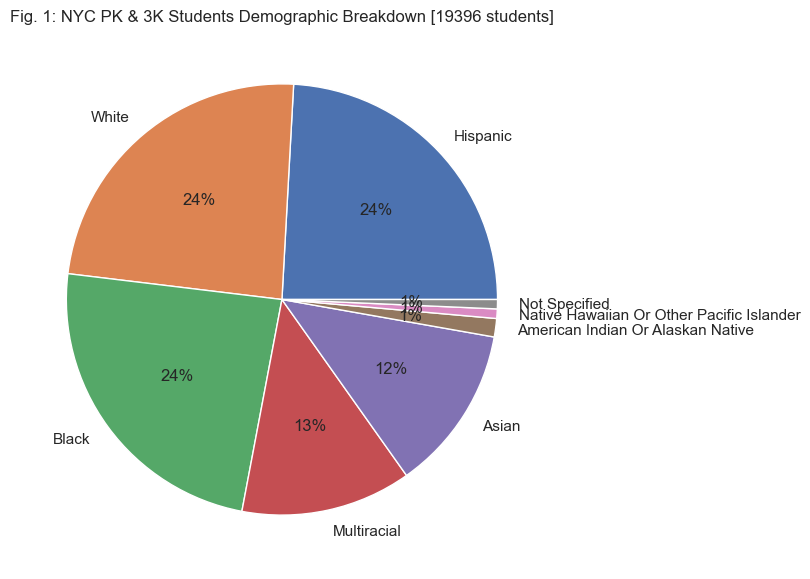

In [427]:
# Pie Chart will use the Student_Clean dataset (not aggregated)
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Students_Clean.head(4)
Students_Clean.Demo.value_counts()
print(Students_Clean.shape)
# We convert a value_counts to a datatable
d = Students_Clean.Demo.value_counts().rename_axis('Demographic').reset_index(name='Count')
print(d.shape)

# Creating plot
fig = plt.figure(figsize=(10, 7))
plt.pie(d.Count, labels=d.Demographic, autopct='%1.0f%%')
plt.title("Fig. 1: NYC PK & 3K Students Demographic Breakdown [19396 students]")

# show plot
plt.show()



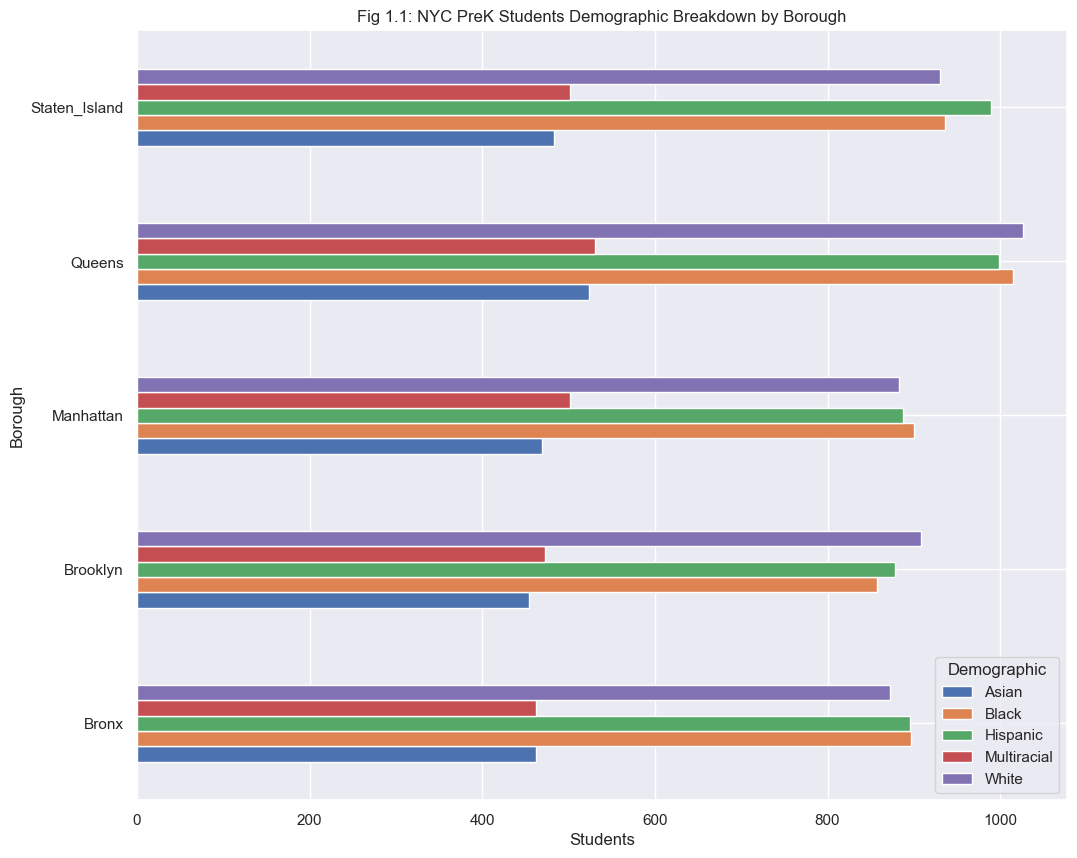

In [418]:
# The bar graph from Boroughs would need to merge data from Score
p=['SiteID','Borough'] #columns of interest
m=Final1[p] #The Final1 datadrame has necessary info
Students_Clean.rename(columns={'AssignedSiteID':'SiteID'},inplace= True) #needed to rename column for merge
Student_Borough= pd.merge(Students_Clean, m, on='SiteID', how='right')

# exclude demographics with less than 1%; makes a better graph
d= Student_Borough.query("Demo in ('White','Black','Asian','Hispanic','Multiracial')")

# value_counts on two variables and convert to table
f= d[["Borough", "Demo"]].value_counts().rename_axis(['Borough','Demographic']).reset_index(name='Count')
g= f.sort_values(by=['Borough','Demographic']) #sort data

# Seaborn bar graph
sns.set()
pd.pivot_table(g, values='Count', index=['Borough'], columns=['Demographic'], 
                          fill_value=0).plot(kind= 'barh', 
                                             figsize=(12,10),title= 'Fig 1.1: NYC PreK Students Demographic Breakdown by Borough')
plt.xlabel ('Students')
plt.show()



In [326]:
Final1.head(3)

,SourceSiteID,_3KScore,PKScore,Borough,SiteID,ProgramName,ProgAddDateTime,ProgValidity,Users
0,92MO2V,37.3,87.4,Manhattan,948726,CBO,2024-12-23,Maybe,7
1,MB40,86.9,82.5,Manhattan,928529,CBO,2024-12-14,Maybe,10
2,95MIPS,52.4,NaN,Manhattan,977582,CBO,2024-10-26,Maybe,15


## 4.2 Housing Status Breakdown <a name="4.2"></a>

* Table will have housing status breakdown by bourough
* Table will have housing insecurity breakdown by bourough

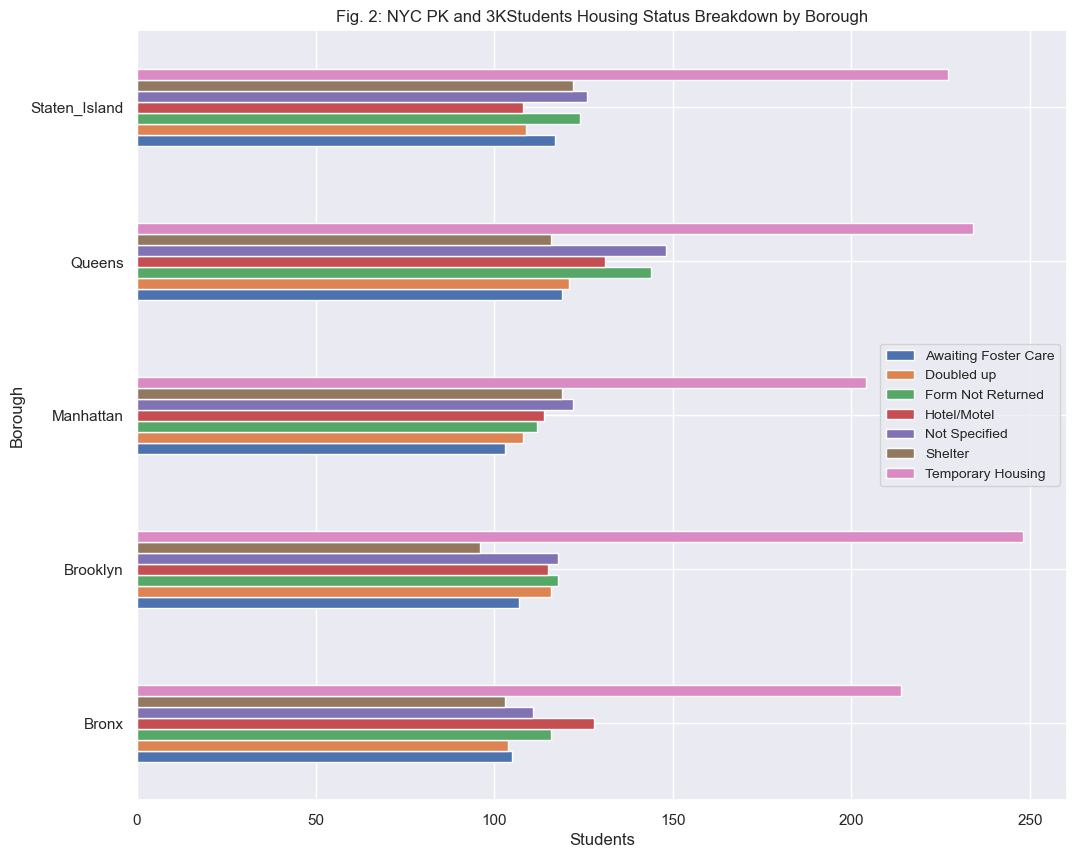

In [428]:
# Bar Chart Housing Status
# exclude demographics with less than 1%; makes a better graph
d= Student_Borough.query("HousingStat not in ('Permanent Housing')")

# value_counts on two variables and convert to table
f= d[["Borough", "HousingStat"]].value_counts().rename_axis(['Borough','Housing Status']).reset_index(name='Count')
g= f.sort_values(by=['Borough','Housing Status']) #sort data

# Seaborn bar graph
sns.set()
pd.pivot_table(g, values='Count', index=['Borough'], columns=['Housing Status'], 
                          fill_value=0).plot(kind= 'barh', 
                                             figsize=(12,10),title= 'Fig. 2: NYC PK and 3KStudents Housing Status Breakdown by Borough')
plt.legend(fontsize=10)
plt.xlabel ('Students')
plt.show()

Housing Insecurity is when students do not have permanent housing


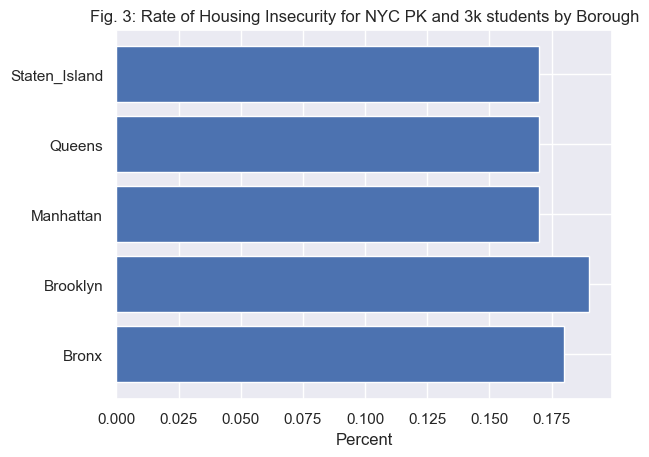

In [429]:
# Bar Chart
a=Student_Borough
a['Dex']=1
p=['Borough','HousingInSecurity_Dum','Dex']
b=a[p].groupby(['Borough',]).sum().reset_index() #the reset index is important for AssignedSiteID to separate

b['HousingInsecure_Percent']= round(b.HousingInSecurity_Dum/ b.Dex,2)

p= ['Borough','HousingInsecure_Percent']
data= b[p]
#sns.barplot(data, x="Borough", y="HousingInsecure_Percent")
print('Housing Insecurity is when students do not have permanent housing')
plt.barh(data.Borough, data.HousingInsecure_Percent)
plt.title("Fig. 3: Rate of Housing Insecurity for NYC PK and 3k students by Borough")
plt.xlabel('Percent')
plt.show()

## 4.3 Visualization Free & Reduced Lunch <a name="4.3"></a>

### Approach
* A simple pie chart for city level. I did not separate free and reduced lunch because easily be added 
* Percent of free and reduced lunch by bourough

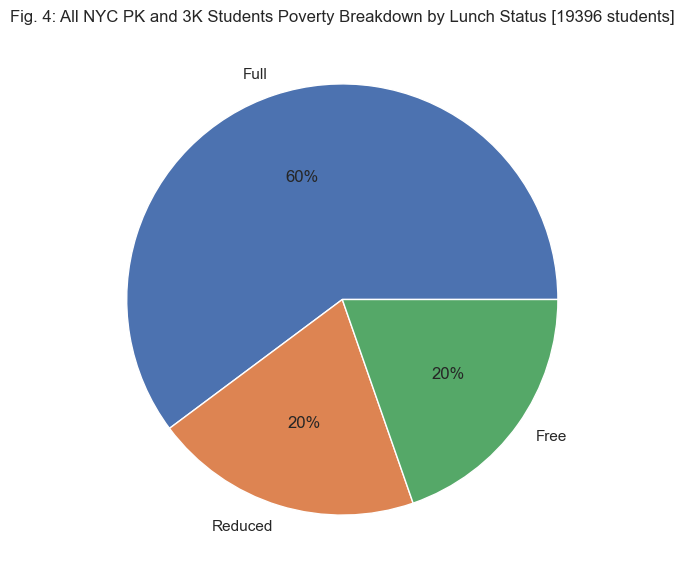

In [430]:
# Pie Chart
# We convert a value_counts to a datatable
d = Students_Clean.Lunch.value_counts().rename_axis('Lunch').reset_index(name='Count')

# Creating plot
fig = plt.figure(figsize=(10, 7))
plt.pie(d.Count, labels=d.Lunch, autopct='%1.0f%%')
plt.title("Fig. 4: All NYC PK and 3K Students Poverty Breakdown by Lunch Status [19396 students]")


# show plot
plt.show()

Students are in poverty if they recieve free or reduced lunch


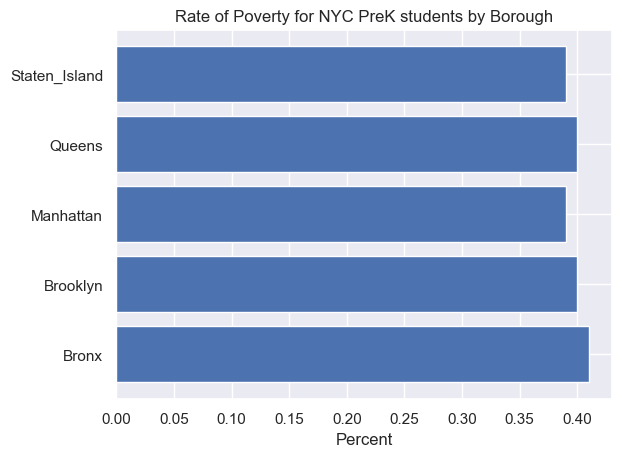

In [381]:


# exclude demographics with less than 1%; makes a better graph
d= Student_Borough.query("Lunch in ('Free','Reduced')")

a=Student_Borough
a['Dex']=1
p=['Borough','Poverty_Dum','Dex']
b=a[p].groupby(['Borough',]).sum().reset_index() #the reset index is important for AssignedSiteID to separate

b['Poverty_Percent']= round(b.Poverty_Dum/ b.Dex,2)

p= ['Borough','Poverty_Percent']
data= b[p]


# Graph
print('Students are in poverty if they recieve free or reduced lunch')
plt.barh(data.Borough, data.Poverty_Percent)
plt.title("Rate of Poverty for NYC PreK students by Borough")
plt.xlabel ('Percent')
#plt.savefig('Poverty_Borough.png')
plt.show()



## Programmer Note <a name="note"></a>

This was brutal, but I have still have the skills

In [389]:
Final1.	ProgValidity.value_counts()

Maybe    489
Yes        7
Name: ProgValidity, dtype: int64